In [60]:
from datasets import DatasetDict, load_dataset
from matplotlib import pyplot as plt
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from transformers import AutoFeatureExtractor, AutoModel

In [7]:
model_ckpt = "nateraw/vit-base-beans"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size

/home/userr/micromamba/envs/manga311/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/userr/micromamba/envs/manga311/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
dataset: DatasetDict = load_dataset("beans") # type: ignore

In [9]:
dataset["train"].features

{'image_file_path': Value(dtype='string', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'labels': ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)}

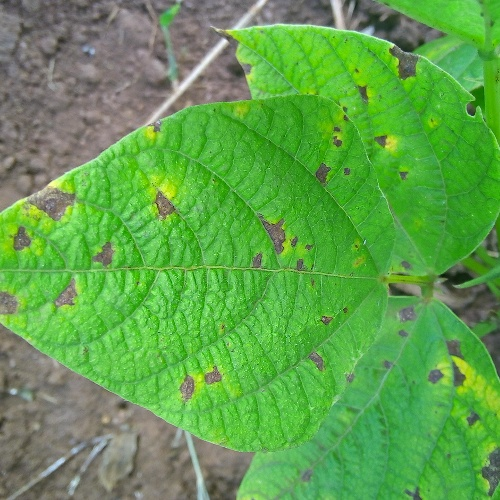

In [10]:
dataset["train"][3]["image"]

In [19]:
num_samples = 100
seed = 42
subset = dataset["train"].shuffle(seed=seed)
candidate_subset = subset.select(range(num_samples))
test_subset = subset.select(range(num_samples, num_samples + 100))

In [12]:
import torchvision.transforms as T


# Data transformation chain.
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

In [33]:
import torch 

def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def pp(batch):
        images = batch["image"]
        # `transformation_chain` is a compostion of preprocessing
        # transformations we apply to the input images to prepare them
        # for the model. For more details, check out the accompanying Colab Notebook.
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings: torch.Tensor = model(**new_batch).last_hidden_state[:, 0].cpu()
        return {"embeddings": embeddings.numpy()}

    return pp


In [34]:
# Here, we map embedding extraction utility on our subset of candidate images.
batch_size = 24
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device))
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=24)
test_subset_emb = test_subset.map(extract_fn, batched=True, batch_size=24)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [16]:
candidate_subset

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 100
})

In [23]:
test_subset

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 100
})

In [43]:
dataset_with_embeddings = candidate_subset_emb.select_columns(["image", "embeddings"])
test_dataset_with_embeddings = test_subset_emb.select_columns(["image", "embeddings"])
dataset_with_embeddings.set_format("torch")
test_dataset_with_embeddings.set_format("torch")

In [44]:
dataset_with_embeddings.add_faiss_index(column="embeddings")

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'embeddings'],
    num_rows: 100
})

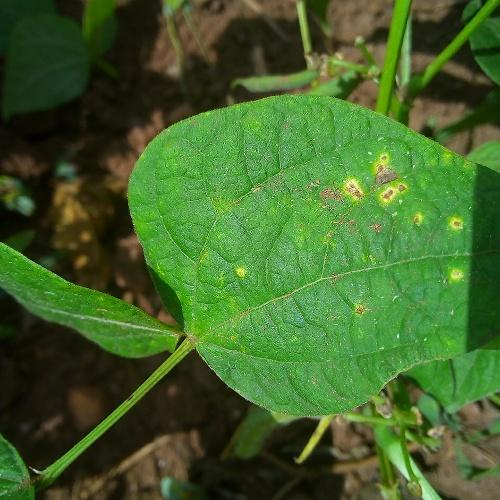

In [79]:
to_pil_image(dataset_with_embeddings["image"][0])

In [77]:
top_k = 5
qi_embedding = dataset_with_embeddings[0]["embeddings"].numpy()

scores, retrieved_examples = dataset_with_embeddings.get_nearest_examples(
    "embeddings", qi_embedding, k=top_k
)

Score: 0.0


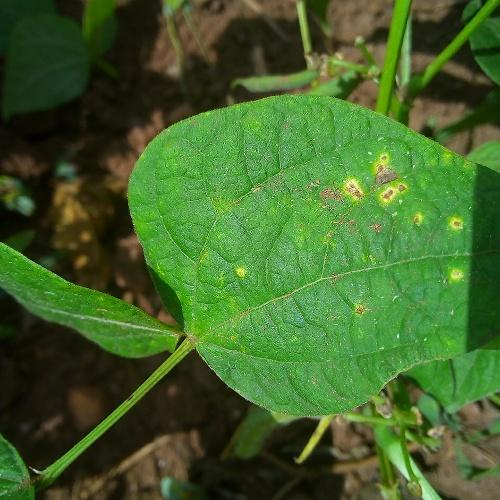

Score: 4.673268795013428


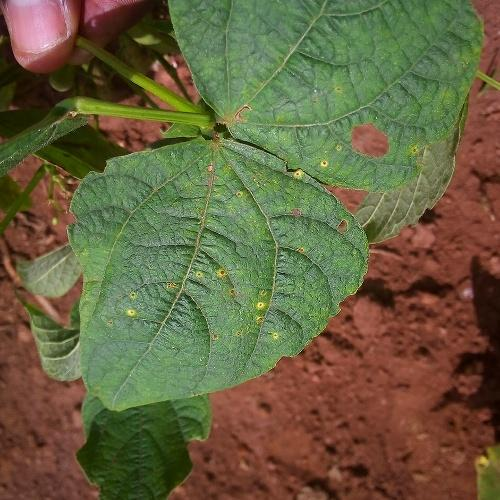

Score: 4.708878040313721


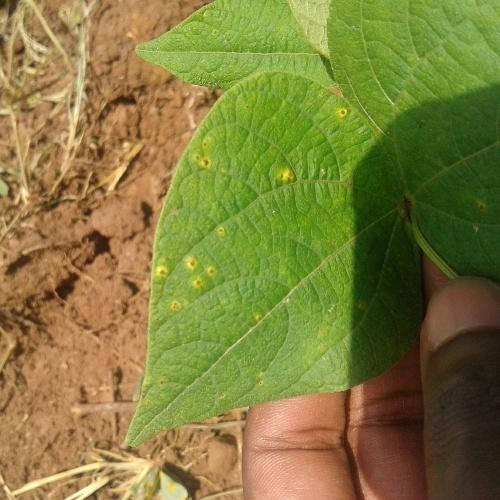

Score: 4.738353729248047


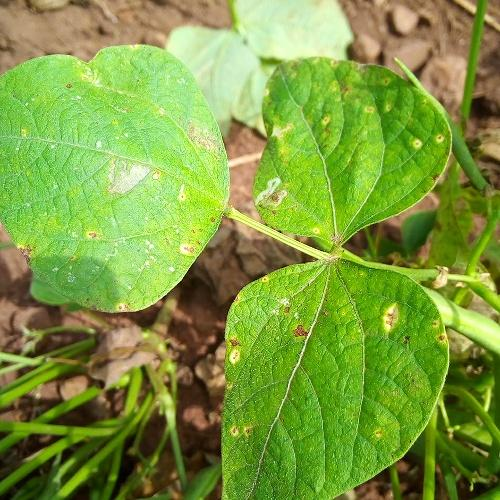

Score: 4.950196266174316


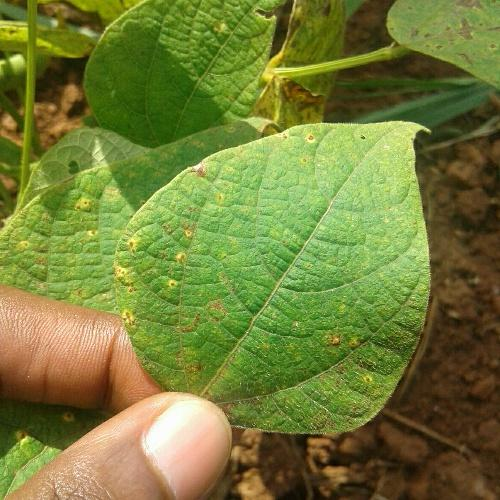

In [78]:
for score, img in zip(scores, retrieved_examples["image"]):
    print(f"Score: {score}")
    to_pil_image(img).show()

In [ ]:
import numpy as np

all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings)